In [15]:
import cv2
import numpy as np
import os
from tqdm import tqdm

# showing image
def show_image(image, title="Image", scale=5):
    h, w = image.shape
    resized_image = cv2.resize(image, (w * scale, h * scale), interpolation=cv2.INTER_NEAREST)
    cv2.imshow(title, resized_image)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    
# load data

final_data = "C:/Users/HUY/Desktop/my_project/final_data"
synthetic_path = "C:/Users/HUY/Desktop/my_project/synthetic_data"

# tải dữ liệu dựa theo góc của dáng đi
def load_view(folder_paths, view):
    train, test = [], []
    train_view = []
    test_view = []
    for folder in (os.listdir(folder_paths)):
        if folder == "train":
            tr_labels = []
            for img in os.listdir(f"{folder_paths}/{folder}"):
                if view in img:
                    im = np.array(cv2.imread(f"{folder_paths}/{folder}/{img}", cv2.IMREAD_GRAYSCALE))
                    tr_labels.append(img[0:3])
                    train.append(im)
                    train_view.append(view)
        if folder == "test":
            te_labels = []
            for img in os.listdir(f"{folder_paths}/{folder}"):
                if view in img:
                    im = np.array(cv2.imread(f"{folder_paths}/{folder}/{img}", cv2.IMREAD_GRAYSCALE))
                    te_labels.append(img[0:3])
                    test.append(im)
                    test_view.append(view)
    # print(f"Hoàn thành tải dữ liệu lên từ {folder_paths} với góc {view} độ")
    return train, test, tr_labels, te_labels, train_view, test_view


# tải dữ liệu dáng đi với tất cả các góc
def load_data(view = "crossview"):
    
    views = ["000","018","036","054","072","090","108","126","144","162","180"]
    x_train, y_train = [], []
    x_test, y_test = [], []
    train_view, test_view = [], []
    
    if view in views:
        views = [view]
    
    for view in tqdm(views):
        x_rtrain_view, x_rtest_view, y_rtrain_view, y_rtest_view, rtrain_view, rtest_view = load_view(final_data, view)
        x_strain_view, x_stest_view, y_strain_view, y_stest_view, strain_view, stest_view = load_view(synthetic_path, view)
        
        x_train = x_train + x_rtrain_view + x_strain_view
        y_train = y_train + y_rtrain_view + y_strain_view
        x_test = x_test + x_rtest_view + x_stest_view
        y_test = y_test + y_rtest_view + y_stest_view
        train_view = train_view + rtrain_view + strain_view
        test_view = test_view + rtest_view + stest_view
        
    print(f"✅ Kích thước tập train và nhãn: {len(x_train)} và {len(y_train)}")
    print(f"✅ Kích thước tập test và nhãn: {len(x_test)} và {len(y_test)}")
    return x_train, y_train, x_test, y_test, train_view, test_view

In [16]:
x_train, y_train, x_test, y_test, train_view, test_view = load_data(view = "crossview")

100%|██████████| 11/11 [00:06<00:00,  1.76it/s]

✅ Kích thước tập train và nhãn: 12792 và 12792
✅ Kích thước tập test và nhãn: 8528 và 8528


In [3]:
import pandas as pd
from sklearn.decomposition import PCA  

# 95 -> 14 ~ 13
# 96 -> 15 ~ 14
# 97 -> 16 ~ 15
# 98 -> 17 ~ 16
# 99 -> 18 ~ 17
# ==> chọn số component = 18 để khảo sát accuracy từ 1-->18

pca = PCA(n_components = 18)
x_train = pca.fit_transform([x.flatten() for x in x_train])

base_vector = pca.components_

x_test = pca.transform([x.flatten() for x in x_test])

print(f"Kích thước của tập train và test sau khi PCA: {x_train.shape} {x_test.shape}")

data_path = ['data_train.csv', 'data_test.csv']

df_train = pd.DataFrame(x_train)
df_train['label'] = y_train
df_train['view'] = train_view
df_train.to_csv( data_path[0], index=False)

df_test = pd.DataFrame(x_test)
df_test['label'] = y_test
df_test['view'] = test_view
df_test.to_csv( data_path[1], index=False)

for path in data_path:
    if os.path.exists(path):
        print(f"✅ Đã tạo file {path} thành công!")

Kích thước của tập train và test sau khi PCA: (12792, 18) (8528, 18)
✅ Đã tạo file data_train.csv thành công!
✅ Đã tạo file data_test.csv thành công!


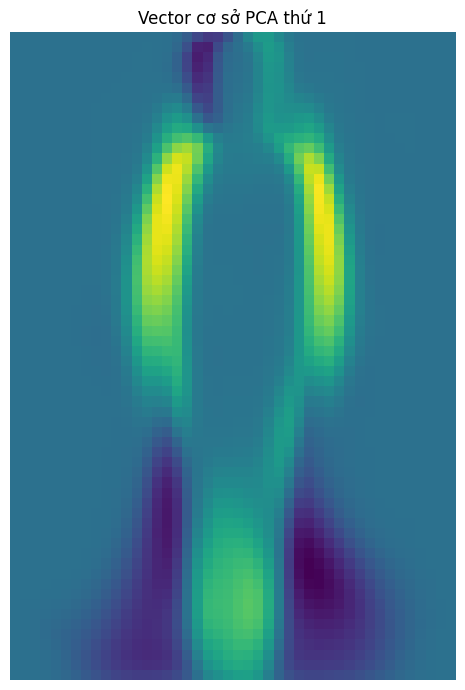

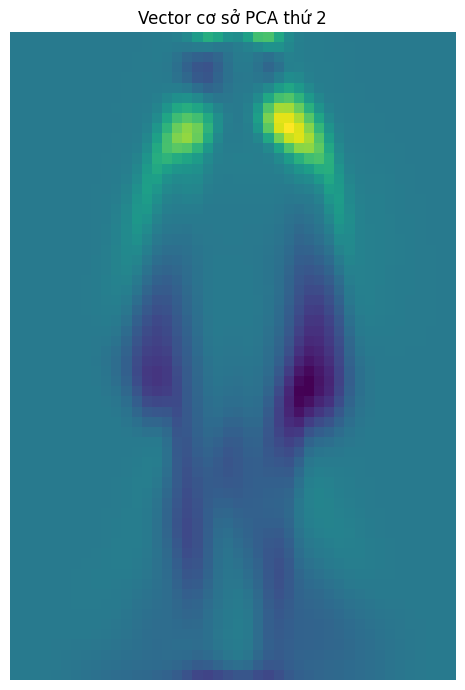

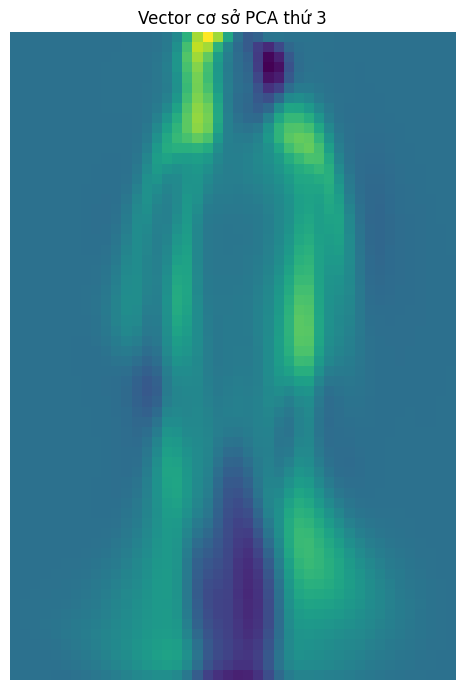

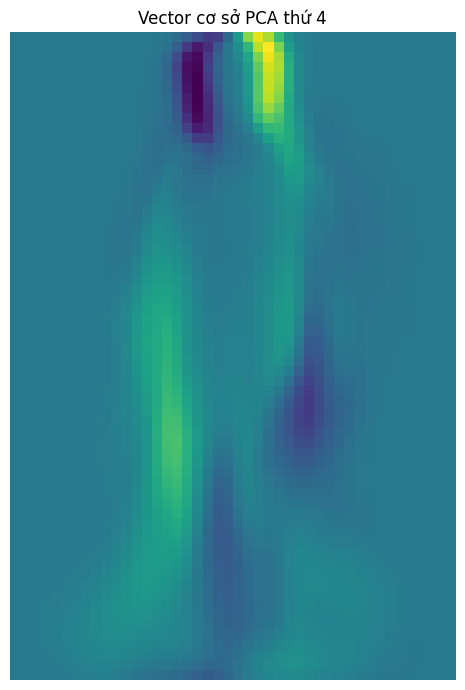

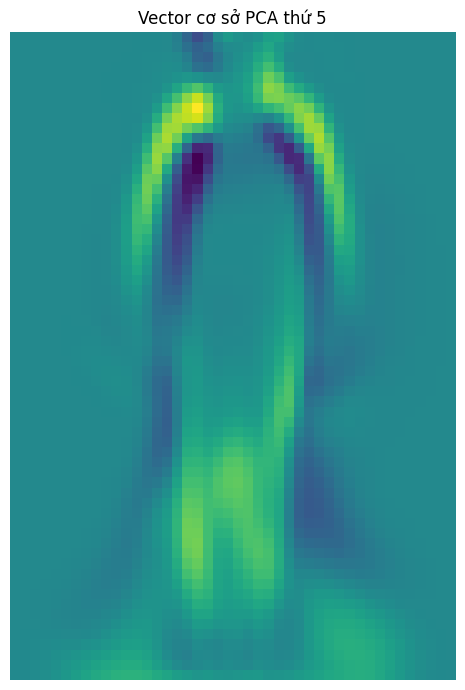

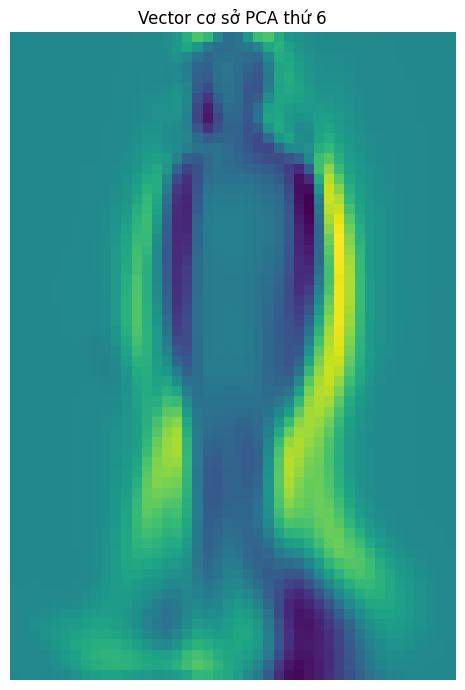

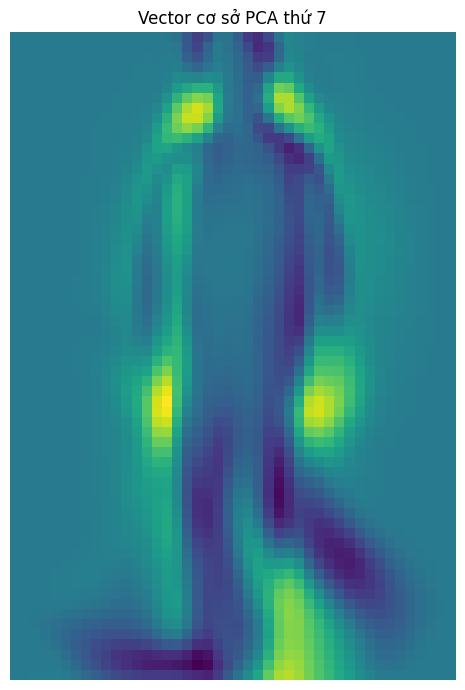

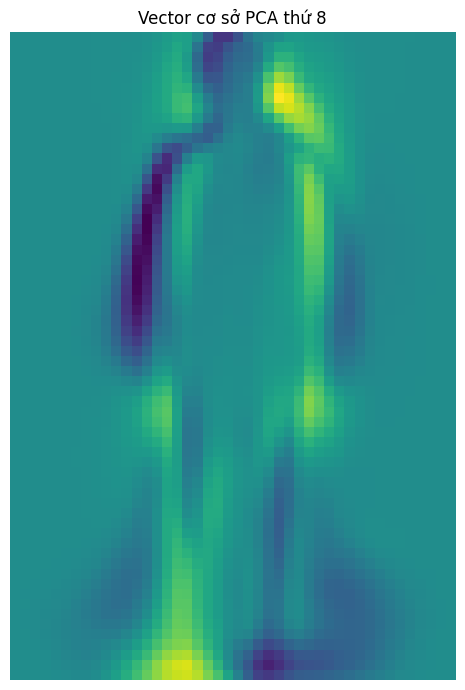

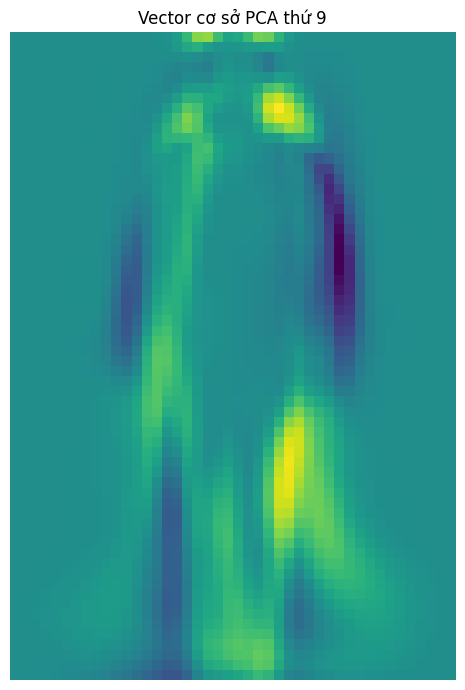

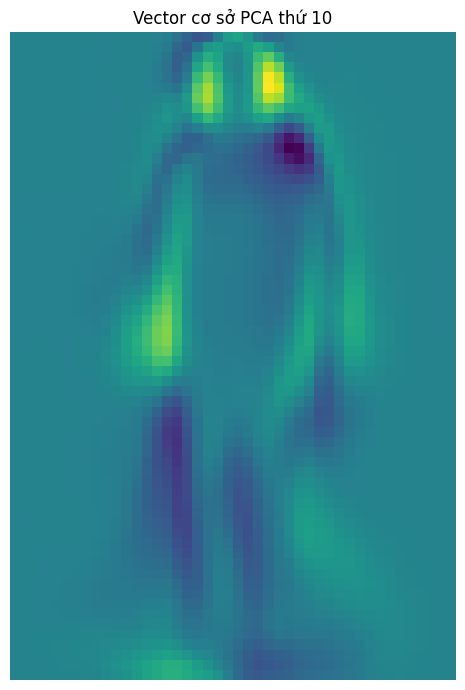

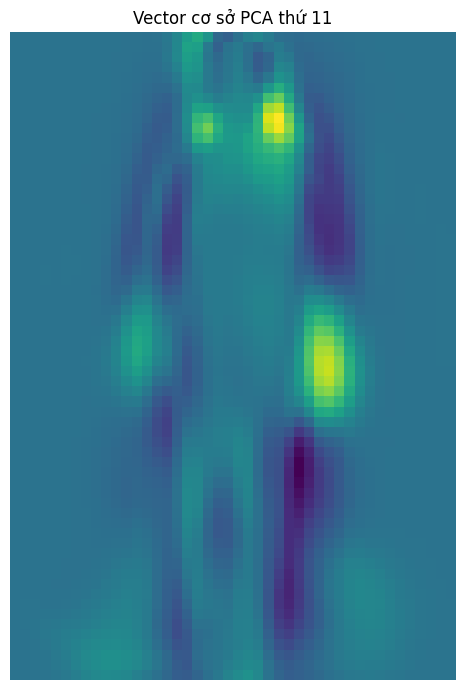

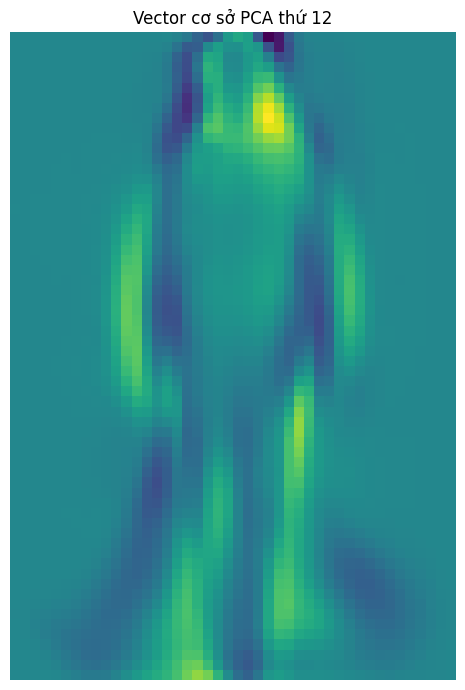

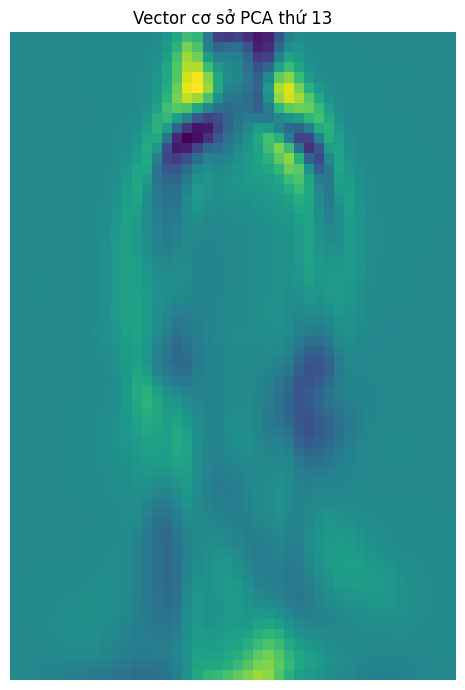

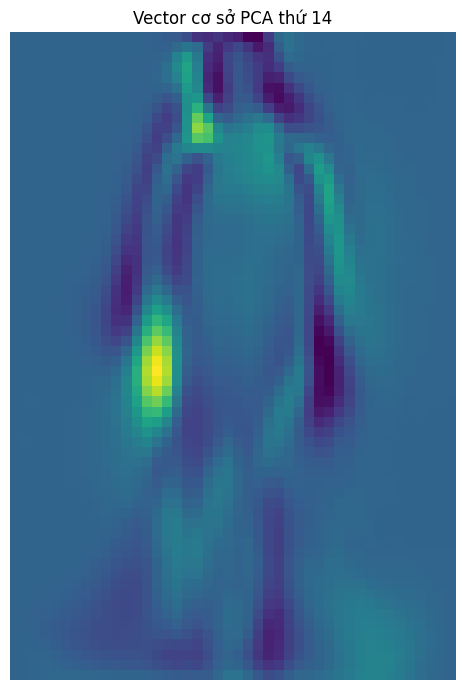

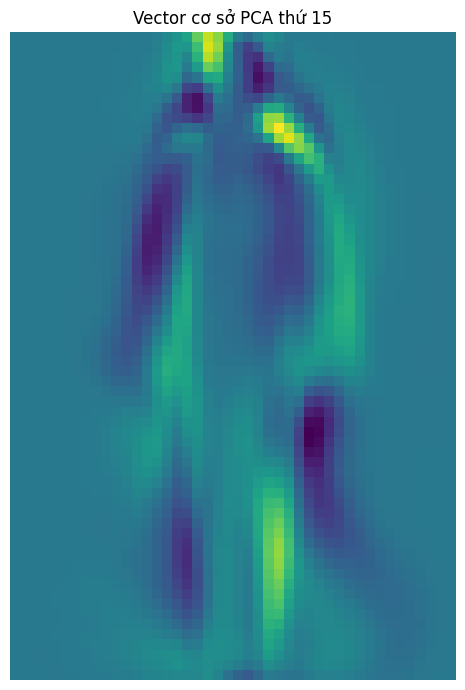

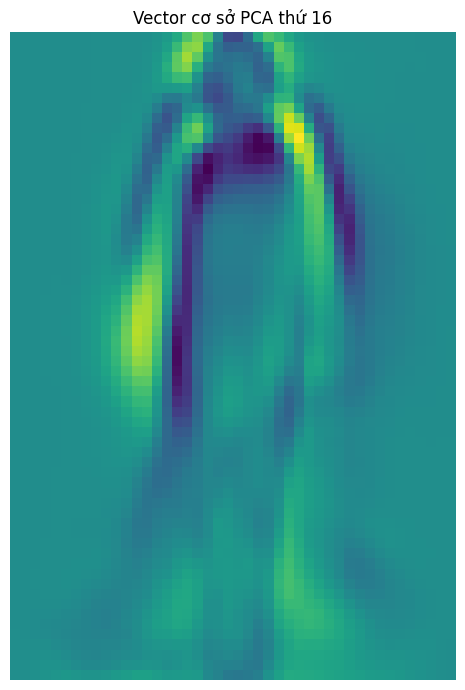

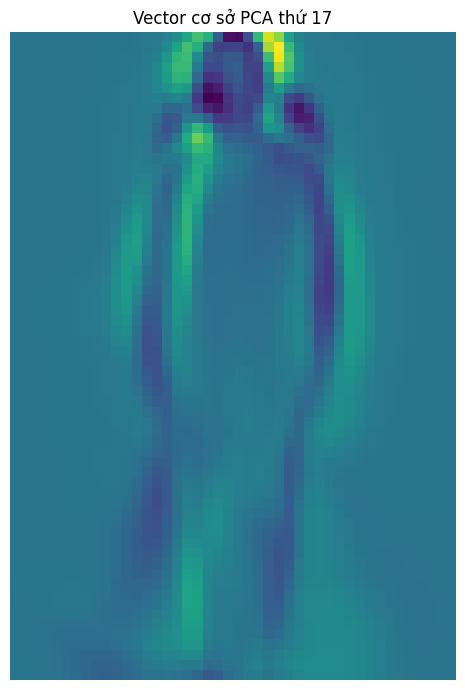

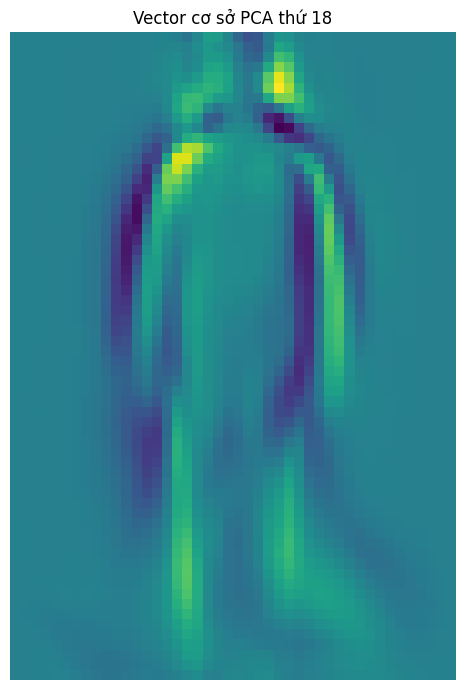

In [4]:
import matplotlib.pyplot as plt

for i, component in enumerate(pca.components_):
    image = np.array(component.reshape(64, 44))
    minn, maxx = np.min(image), np.max(image)
    
    fig, ax = plt.subplots(1,1, figsize = (15,7))

    image_normalized = ((image - minn) / abs(maxx-minn)) * 255    
    image_uint8 = image_normalized.astype(np.uint8)
    ax.imshow(image_uint8)
    ax.set_title(f'Vector cơ sở PCA thứ {i+1}')
    ax.axis('off')
    plt.tight_layout()
    plt.show()

In [64]:
# Đã hoàn thành trích xuất đặc trưng bằng PCA cho dataset
# Lưu các đặc trưng đó thành các file csv để xử lý sau
# ===> OKE